## Nikita Puchkin

# Manifold denoising with application to semi-supervised learning

## The datasets are available at http://olivier.chapelle.cc/ssl-book/benchmarks.html

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

## Structure-adaptive manifold estimator (SAME)

### The description is available at https://arxiv.org/abs/1906.05014

In [2]:
# Manifold denoising procedure
#
# Y -- (n_samples x n_features)-array of noisy observations,
# generated from the model Y_i = X_i + eps_i, 1 <= i <= n_samples,
# where X_i lies on a manifold and eps_i is a perpendicular
# zero-mean noise
#
# projectors_list -- list of initial guesses of projectors
# onto tangent spaces at the points X_1, ..., X_n
#
# bandwidths_list -- a decreasing sequence of bandwidths
#
# d -- manifold dimension
#
# tau -- threshold parameter, must be less than the reach
# of the manifold
#
def SAME(Y, projectors_list, bandwidths_list, d, tau, gamma=4.0):
    
    # number of iterations
    n_iterations = len(bandwidths_list)
    # sample size
    n = Y.shape[0]
    # dimension of the ambient space
    D = Y.shape[1]
    
    # Initialization
    X = Y[:,:]
    projectors = projectors_list
    
    for k in range(n_iterations):
        
        # pairwise distances
        dist = pairwise_distances(Y)
        
        # compute adjusted distances
        a_dist = np.empty((0, n))
        for i in range(n):
            
            # distances to the i-th point
            a_dist_i = np.linalg.norm(projectors[i] @ ((Y - Y[i,:]).transpose()), axis=0).reshape(1, -1)
            a_dist = np.append(a_dist, a_dist_i, axis=0)
            
        # compute weights
        h = bandwidths_list[k]
        W = np.exp(-a_dist**2/h**2) * (dist < tau)
        
        # compute the adjusted Nadaraya-Watson estimate
        X = W.dot(Y) / np.tile(np.sum(W, axis=1).reshape(-1, 1), (1, Y.shape[1]))
        
        # compute the projectors
        if k < n_iterations-1:
            for i in range(n):

                # compute weighted covariance
                X0 = X[i, :]
                x_dist = np.linalg.norm(X - X0, axis=1)
                weights = 1 * (x_dist < gamma * h)
                
                X_weighted = np.diag(weights**0.5) @ (X - X0)
                u, s, vt = np.linalg.svd(X_weighted, full_matrices=False)
                
                # update the i-th projector
                projectors[i] = np.dot(vt[:d, :].transpose(), vt[:d, :])
    
    return X, projectors

# g241c dataset

### Dataset preprocessing

In [3]:
# Load data
data = loadmat('g241c_data.mat')

In [4]:
# Features
X = data['X']
# Labels
y = data['y']

y = y.reshape(-1)

print(X.shape, y.shape)

(1500, 241) (1500,)


In [5]:
# Split the data into train and test sets
n_train = 100
n_test = X.shape[0] - n_train

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=n_test, random_state=1)

print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(100, 241) (100,) (1400, 241) (1400,)


In [6]:
# Merge all the feature vectors 
X_all = np.append(X_tr, X_te, axis=0)
print(X_all.shape)

(1500, 241)


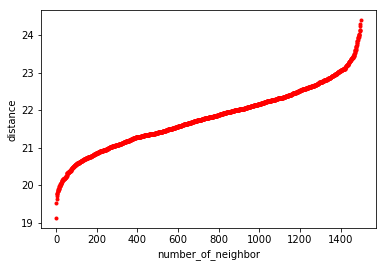

In [7]:
% matplotlib inline

# Fix a point and look at the distance to the closest neighbors
# This helps to choose tau and initial bandwidth

X0 = X_all[0]
dist = np.linalg.norm(X_all - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure()
plt.plot(np.arange(X_all.shape[0]-1), dist_sorted[1:], 'r.')
plt.xlabel('number_of_neighbor')
plt.ylabel('distance')
plt.show()
plt.close()

### Classification without denoising

In [8]:
# Create a nearest neighbor classifier
n_neighbors = 21
kNN = KNeighborsClassifier(n_neighbors=n_neighbors)

In [9]:
# Fit
kNN.fit(X_tr, y_tr)
# Predict
y_pr = kNN.predict(X_te)
print('Error without denoising:', np.sum(y_pr != y_te) / n_test)

Error without denoising: 0.31285714285714283


### Denoising

In [10]:
# Ambient dimension
D = X_all.shape[1]
# Intrinsic dimension
d = 10
# Sample size
n_samples = X_all.shape[0]

n_iterations = 2
a = 1.2
bandwidths = 20 * a**(-np.arange(n_iterations))
print(bandwidths)
projectors = [np.identity(D)] * n_samples

[20.         16.66666667]


In [11]:
# Denoising
X_denoised, projectors = SAME(X_all, projectors, bandwidths, d=d, tau=22)
# Show the average change
print(np.linalg.norm(X_denoised - X_all, ord='fro')**2 / n_samples)        

218.5060711593772


In [12]:
# Split back into train and test points
X_denoised_tr = X_denoised[:X_tr.shape[0]]
X_denoised_te = X_denoised[X_tr.shape[0]:]

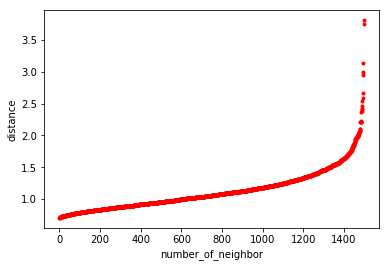

In [13]:
%matplotlib inline

# Look the the distance to the neighbors
# The distance to the nearest neighbor was significantly reduced

X0 = X_denoised[0]
dist = np.linalg.norm(X_denoised - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure()
plt.plot(np.arange(X_all.shape[0]-1), dist_sorted[1:], 'r.')
plt.xlabel('number_of_neighbor')
plt.ylabel('distance')
plt.show()
plt.close()

### Classification after denoising

In [14]:
# Create a nearest neighbor classifier
n_neighbors = 15
kNN = KNeighborsClassifier(n_neighbors=n_neighbors)

In [15]:
# Fit
kNN.fit(X_denoised_tr, y_tr)
# Predict
y_pr = kNN.predict(X_denoised_te)
print('Error after denoising:', np.sum(y_pr != y_te) / n_test)

Error after denoising: 0.27785714285714286


# g241n dataset

### Dataset preprocesssing

In [16]:
# Load data
data = loadmat('g241n_data.mat')

In [17]:
# Features
X = data['X']
# Labels
y = data['y']

y = y.reshape(-1)

print(X.shape, y.shape)

(1500, 241) (1500,)


In [18]:
# Split the data into train and test sets
n_train = 100
n_test = X.shape[0] - n_train

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=n_test, random_state=1)

print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

(100, 241) (100,) (1400, 241) (1400,)


In [19]:
# Merge all the feature vectors 
X_all = np.append(X_tr, X_te, axis=0)
print(X_all.shape)

(1500, 241)


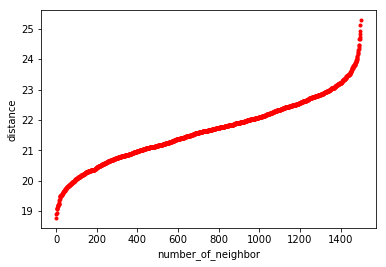

In [21]:
% matplotlib inline

# Fix a point and look at the distance to the closest neighbors
# This helps to choose tau and initial bandwidth

X0 = X_all[0]
dist = np.linalg.norm(X_all - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure()
plt.plot(np.arange(X_all.shape[0]-1), dist_sorted[1:], 'r.')
plt.xlabel('number_of_neighbor')
plt.ylabel('distance')
plt.show()
plt.close()

### Classification without denoising

In [22]:
# Create a nearest neighbor classifier
n_neighbors = 18
kNN = KNeighborsClassifier(n_neighbors=n_neighbors)

In [23]:
# Fit
kNN.fit(X_tr, y_tr)
# Predict
y_pr = kNN.predict(X_te)
print('Error without denoising:', np.sum(y_pr != y_te) / n_test)

Error without denoising: 0.27071428571428574


### Denoising

In [24]:
# Ambient dimension
D = X_all.shape[1]
# Intrinsic dimension
d = 6
# Sample size
n_samples = X_all.shape[0]

n_iterations = 3
a = 1.2
bandwidths = 20 * a**(-np.arange(n_iterations))
print(bandwidths)
projectors = [np.identity(D)] * n_samples

[20.         16.66666667 13.88888889]


In [25]:
# Denoising
X_denoised, projectors = SAME(X_all, projectors, bandwidths, d=d, tau=21)
# Show the average change
print(np.linalg.norm(X_denoised - X_all, ord='fro')**2 / n_samples) 

195.66981231733288


In [26]:
# Split back into train and test points
X_denoised_tr = X_denoised[:X_tr.shape[0]]
X_denoised_te = X_denoised[X_tr.shape[0]:]

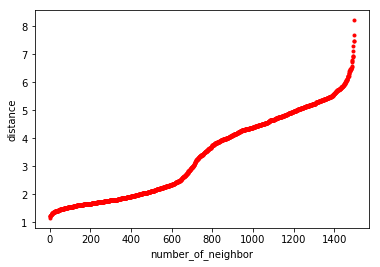

In [27]:
%matplotlib inline

# Look the the distance to the neighbors
# The distance to the nearest neighbor was significantly reduced

X0 = X_denoised[0]
dist = np.linalg.norm(X_denoised - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure()
plt.plot(np.arange(X_all.shape[0]-1), dist_sorted[1:], 'r.')
plt.xlabel('number_of_neighbor')
plt.ylabel('distance')
plt.show()
plt.close()

### Classification after denoising

In [28]:
# Create a nearest neighbor classifier
n_neighbors = 12
kNN = KNeighborsClassifier(n_neighbors=n_neighbors)

In [29]:
# Fit
kNN.fit(X_denoised_tr, y_tr)
# Predict
y_pr = kNN.predict(X_denoised_te)
print('Error after denoising:', np.sum(y_pr != y_te) / n_test)

Error after denoising: 0.25285714285714284
